# Customer RFM Segmentation
Customer segmentation used to target shipping cost voucher receiver candidate. As stated on my analysis before, the use of voucher doesn't seem to have any effect on user's satisfaction. However, this strategy may be able to increase user retention. Since the majority of users only order at most 2 times in the span of 2 years this is a severe problem for the ecommerce. Therefore a strategy needed to be laid out to increase user transaction frequency and monetary value.

## Free Shipping Cost Voucher Strategy
Shipping cost voucher will be awarded to customer which has lower transaction frequency but relatively higher monetary value. Not only that, but customer will be able to use the voucher only after it fulfill some conditions such as minimum transaction value, applied only to Official Store, or on certain occassion or date.

## Library Import and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# import postgres connection factory utility
from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': 'localhost',
    'port': '8084',
    'dbname': 'warehouse'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [4]:
customer_recency_query = "SELECT \
    user_name, \
    last_order_interval,  \
    EXTRACT (epoch from last_order_interval/3600) AS hour_since_last_order \
FROM \
    mart_customer_recency \
; \
"
customer_recency = pd.read_sql(customer_recency_query, con=postgres_conn)
display(customer_recency.head(5))
display(customer_recency.describe())

,user_name,last_order_interval,hour_since_last_order
0,8cdbbdb32c682663f17135569a85c24f,383 days 02:29:57,9194.499167
1,b3ab1572fdb4a1c2e6862a3ea20e68dc,287 days 02:56:37,6890.943611
2,ba4a42117e2f671a90e2a16844cb28f2,429 days 00:30:41,10296.511389
3,10b6d571eedd3e1bbf10521ee704dcd4,246 days 22:53:32,5926.892222
4,ed91e29ad9cf4fad5935469b0e91e792,129 days 04:53:13,3100.886944


,last_order_interval,hour_since_last_order
count,94986,94986.000000
mean,288 days 10:34:55.245594096,6922.582013
std,153 days 00:02:46.167522262,3672.046158
min,45 days 08:23:21,1088.389167
25%,164 days 07:22:31.500000,3943.375417
50%,269 days 03:14:47,6459.246389
75%,397 days 07:18:33.500000,9535.309306
max,773 days 20:14:59,18572.249722


In [5]:
customer_frequency_query = "SELECT \
    user_name, \
    order_count, \
    avg_time_between_order, \
    EXTRACT (epoch from avg_time_between_order/3600) AS avg_hour_between_orders \
FROM \
    mart_customer_order_frequency"
customer_frequency = pd.read_sql(customer_frequency_query, con=postgres_conn)
display(customer_frequency.head(5))
display(customer_frequency.describe())

,user_name,order_count,avg_time_between_order,avg_hour_between_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0 days,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0 days,0.0
2,0000f46a3911fa3c0805444483337064,1,0 days,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0 days,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,0 days,0.0


,order_count,avg_time_between_order,avg_hour_between_orders
count,94986.000000,94986,94986.000000
mean,1.033858,2 days 10:43:51.761414313,58.731045
std,0.210807,23 days 08:52:28.579968842,560.874606
min,1.000000,0 days 00:00:00,0.000000
25%,1.000000,0 days 00:00:00,0.000000
50%,1.000000,0 days 00:00:00,0.000000
75%,1.000000,0 days 00:00:00,0.000000
max,16.000000,608 days 23:29:38,14615.493889


In [6]:
customer_mv_query = "SELECT * FROM fact_customer_monetary_value"
customer_monetary_value = pd.read_sql(customer_mv_query, con=postgres_conn)
display(customer_monetary_value.head(5))
display(customer_monetary_value.describe())

,state_id,state,user_sk,order_date,avg_spending,highest_spending,lowest_spending,avg_shipping_cost_vs_price_ratio
0,1.0,ACEH,1.0,20170424.0,297140.0,297140.0,297140.0,0.104610
1,1.0,ACEH,1.0,NaN,297140.0,297140.0,297140.0,0.104610
2,1.0,ACEH,2.0,20170522.0,130560.0,130560.0,130560.0,0.135304
3,1.0,ACEH,2.0,NaN,130560.0,130560.0,130560.0,0.135304
4,1.0,ACEH,3.0,20180129.0,237000.0,237000.0,237000.0,0.102326


,state_id,user_sk,order_date,avg_spending,highest_spending,lowest_spending,avg_shipping_cost_vs_price_ratio
count,192292.000000,192258.000000,9.727200e+04,1.922870e+05,1.922870e+05,1.922870e+05,192287.000000
mean,13.048239,48061.389908,2.017605e+07,1.605895e+05,1.621959e+05,1.596615e+05,0.308953
std,9.229428,27737.044017,4.870463e+03,2.194887e+05,2.295727e+05,2.191479e+05,0.315183
min,1.000000,1.000000,2.016090e+07,9.590000e+03,9.590000e+03,9.590000e+03,0.000000
25%,7.000000,24049.000000,2.017091e+07,6.225000e+04,6.243000e+04,6.169000e+04,0.132120
50%,10.000000,48071.500000,2.018012e+07,1.056500e+05,1.061700e+05,1.047900e+05,0.224680
75%,16.000000,72083.000000,2.018050e+07,1.768950e+05,1.779900e+05,1.758800e+05,0.381619
max,34.000000,96096.000000,2.018090e+07,1.366408e+07,1.366408e+07,1.366408e+07,21.447059


In [7]:
customer_rfm_query = """WITH all_user AS (
SELECT
	DISTINCT od.user_name,
	ud.user_sk,
	ud.customer_state_id AS state_id,
	ud.customer_city AS city
FROM
	order_dim od
LEFT JOIN user_dim ud ON
	od.user_name = ud.user_name
WHERE
	od.order_status NOT IN ('canceled', 'unavailable')),
distinct_fc_monev AS (
SELECT
	*
FROM
	fact_customer_monetary_value fcmv2
WHERE
	user_sk IS NOT NULL
	AND order_date IS NULL)
SELECT
	u.user_name,
	fcmv.avg_spending,
	EXTRACT(epoch FROM mcof.avg_time_between_order/86400)::int8 AS avg_day_between_order,
	mcof.order_count,
	EXTRACT(epoch FROM mcr.last_order_interval/86400)::int8 AS last_order_days
FROM
	all_user u
LEFT JOIN distinct_fc_monev fcmv ON
	u.user_sk = fcmv.user_sk
LEFT JOIN mart_customer_order_frequency mcof ON
	u.user_name = mcof.user_name
LEFT JOIN mart_customer_recency mcr ON
	u.user_name = mcr.user_name;"""
customer_rfm = pd.read_sql(customer_rfm_query, con=postgres_conn)
display(customer_rfm.info())
display(customer_rfm.head(5))
display(customer_rfm.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94990 entries, 0 to 94989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_name              94990 non-null  object 
 1   avg_spending           94983 non-null  float64
 2   avg_day_between_order  94986 non-null  float64
 3   order_count            94986 non-null  float64
 4   last_order_days        94986 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.6+ MB


None

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days
0,00053a61a98854899e70ed204dd4bafe,419180.0,0.0,1.0,232.0
1,000d460961d6dbfa3ec6c9f5805769e1,36680.0,0.0,1.0,284.0
2,000ed48ceeb6f4bf8ad021a10a3c7b43,20750.0,0.0,1.0,151.0
3,0010fb34b966d44409382af9e8fd5b77,61800.0,0.0,1.0,227.0
4,0012929d977a8d7280bb277c1e5f589d,155650.0,0.0,1.0,366.0


,avg_spending,avg_day_between_order,order_count,last_order_days
count,9.498300e+04,94986.000000,94986.000000,94986.000000
mean,1.607270e+05,2.447171,1.033858,288.394627
std,2.198878e+05,23.371340,0.210807,153.005601
min,9.590000e+03,0.000000,1.000000,45.000000
25%,6.241000e+04,0.000000,1.000000,164.000000
50%,1.057400e+05,0.000000,1.000000,269.000000
75%,1.769650e+05,0.000000,1.000000,397.000000
max,1.366408e+07,609.000000,16.000000,774.000000


### Check for Null Value

In [8]:
customer_rfm.isnull().sum()

user_name                0
avg_spending             7
avg_day_between_order    4
order_count              4
last_order_days          4
dtype: int64

## Exploratory Data Analysis

,order_count,user_name
0,1.0,92099
1,2.0,2651
2,3.0,188
3,4.0,29
4,5.0,9
5,6.0,5
6,7.0,3
7,9.0,1
8,16.0,1


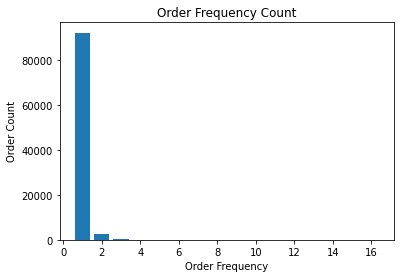

In [112]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_name', 'order_count']] \
        .groupby('order_count', as_index=False).count()
ax.bar(t1['order_count'], t1['user_name'])
ax.set_title('Order Frequency Count')
ax.set_xlabel('Order Frequency')
ax.set_ylabel('Order Count')

display(t1)
plt.show()

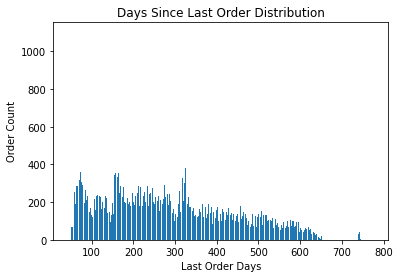

,days_since_last_order,order_count
0,45.0,1
1,50.0,11
2,51.0,38
3,52.0,66
4,53.0,71
5,54.0,68
6,55.0,93
7,56.0,139
8,57.0,181
9,58.0,243


In [101]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_name', 'last_order_days']] \
        .groupby('last_order_days', as_index=False).count()
ax.bar(t1['last_order_days'], t1['user_name'])
ax.set_title('Days Since Last Order Distribution')
ax.set_xlabel('Last Order Days')
ax.set_ylabel('Order Count')

plt.show()
t1.columns = ['days_since_last_order', 'order_count']
display(t1.head(15))

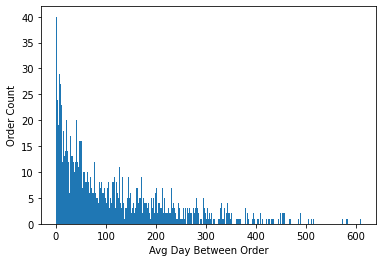

,avg_day_between_order,user_name
0,1.0,40
1,2.0,37
2,3.0,24
3,4.0,25
4,5.0,19


,avg_day_between_order,user_name
394,524.0,2
395,573.0,1
396,581.0,1
397,583.0,1
398,609.0,1


In [12]:
fig, ax = plt.subplots()
t0 = customer_rfm[customer_rfm['order_count'] != 1]
t0 = t0[t0['avg_day_between_order'] != 0]
t1 = t0.loc[:, ['user_name', 'avg_day_between_order']] \
        .groupby('avg_day_between_order', as_index=False).count()
ax.bar(t1['avg_day_between_order'], t1['user_name'])
# ax.set_title('Last Order Days Distribution')
ax.set_xlabel('Avg Day Between Order')
ax.set_ylabel('Order Count')

plt.show()
display(t1.head(5))
display(t1.tail(5))

## Baseline Model
Manually assigned RFM score based on percentile.
<table>
    <tr>
        <th>Recency</th>
        <th>Frequency</th>
        <th>Monetary</th>
    </tr>
    <tr>
        <td>R-Tier-1 (most recent)</td>
        <td>F-Tier-1 (most frequent)</td>
        <td>M-Tier-1 (highest spend)</td>
    </tr>
    <tr>
        <td>R-Tier-2</td>
        <td>F-Tier-2</td>
        <td>M-Tier-2</td>
    </tr>
    <tr>
        <td>R-Tier-3</td>
        <td>F-Tier-3</td>
        <td>M-Tier-3</td>
    </tr>
    <tr>
        <td>R-Tier-4 (least recent)</td>
        <td>F-Tier-4 (least frequent)</td>
        <td>M-Tier-4 (lowest spend)</td>
    </tr>
</table>
Reiterating the goals again, the strategy prefer customer which has lower frequency but relatively higher monetary value. Below are the segment name assignment based on customer RFM score:<br>
<ul>
    <li>High-spending Active Loyal Customer (1-1-1, 1-1-2)</li>
    <li>Churned High-spending Customer* (4-4-1, 4-4-2, 4-3-1, 4-3-2)</li>
    <li>High-spending New Customer* (1-4-1, 1-4-2)</li>
    <li>Worst Customer (4-4-4, 4-3-4, 3-4-4)</li>
</ul>
<b>Note:</b>
* The best candidate to receive free shipping voucher is marked with asterisk

In [13]:
rfm = customer_rfm.copy()

In [14]:
# Tier is reversed since the lowest bin is the least recent
# this rule applies to frequency and monetary as well
recency_labels = [
    4,
    3,
    2,
    1
]
rfm['recency_tier'] = pd.cut(customer_rfm['last_order_days'], bins=4, labels=recency_labels)

In [15]:
frequency_labels = [
    4,
    3,
    2,
    1
]
rfm['frequency_tier'] = pd.cut(customer_rfm['order_count'], bins=4, labels=recency_labels)

In [16]:
monetary_labels = [
    4,
    3,
    2,
    1
]
rfm['monetary_tier'] = pd.cut(customer_rfm['avg_spending'], bins=4, labels=monetary_labels)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier
0,00053a61a98854899e70ed204dd4bafe,419180.0,0.0,1.0,232.0,3,4,4
1,000d460961d6dbfa3ec6c9f5805769e1,36680.0,0.0,1.0,284.0,3,4,4
2,000ed48ceeb6f4bf8ad021a10a3c7b43,20750.0,0.0,1.0,151.0,4,4,4
3,0010fb34b966d44409382af9e8fd5b77,61800.0,0.0,1.0,227.0,4,4,4
4,0012929d977a8d7280bb277c1e5f589d,155650.0,0.0,1.0,366.0,3,4,4


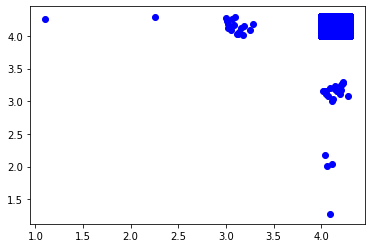

In [17]:
display(rfm.head(5))

# Adding randomness to the scatter plot (for visualization only)
t1 = rfm.copy()
t1['frequency_tier'] = t1.apply(lambda row: row['frequency_tier']+(np.random.rand()*0.3), axis=1)
t1['monetary_tier'] = t1.apply(lambda row: row['monetary_tier']+(np.random.rand()*0.3), axis=1)

fig, ax = plt.subplots()
ax.scatter(t1['frequency_tier'], t1['monetary_tier'], color='b')

In [18]:
high_spending_active_loyal_cust_cond = \
    (rfm['recency_tier'] == 1) \
    & (rfm['frequency_tier'] == 1) \
    & (rfm['monetary_tier'] >= 2)

high_spending_active_loyal_cust = rfm[high_spending_active_loyal_cust_cond]
display(high_spending_active_loyal_cust.head(10))
display(high_spending_active_loyal_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier


(0, 8)

In [19]:
churned_high_spending_cust_cond = \
    (rfm['recency_tier'] <= 3) \
    & (rfm['frequency_tier'] <= 3) \
    & (rfm['monetary_tier'] >= 3)

churned_high_spending_cust = rfm[churned_high_spending_cust_cond]
display(churned_high_spending_cust.head(10))
display(churned_high_spending_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier
27107,48e1ac109decbb87765a3eade6854098,4681780.0,0.0,1.0,118.0,4,4,3
37635,2c3b08cf3584d8c0a81d9618a73aa219,3526460.0,0.0,1.0,192.0,4,4,3
38572,4007669dec559734d6f53e029e360987,6081540.0,0.0,1.0,328.0,3,4,3
39685,58483a1c055dfb600f57c5b867174542,4034440.0,0.0,1.0,135.0,4,4,3
46620,edde2314c6c30e864a128ac95d6b2112,4513320.0,0.0,1.0,76.0,4,4,3
46735,f0767ae738c3d90e7b737d7b8b8bb4d1,3979550.0,0.0,1.0,157.0,4,4,3
47868,0a0a92112bd4c708ca5fde585afaa872,13664080.0,0.0,1.0,384.0,3,4,1
54920,a229eba70ec1c2abef51f04987deb7a5,4445500.0,0.0,1.0,140.0,4,4,3
56138,bc5e25094a7d51b6aee35236572e64f4,3826800.0,0.0,1.0,265.0,3,4,3
74209,3fec1a05177762f279472253113d568a,3792590.0,0.0,1.0,211.0,4,4,3


(14, 8)

In [20]:
high_spending_new_cust_cond = \
    (rfm['recency_tier'] >= 2) \
    & (rfm['frequency_tier'] <= 3) \
    & (rfm['monetary_tier'] >= 3)

high_spending_new_cust = rfm[high_spending_new_cust_cond]
display(high_spending_new_cust.head(10))
display(high_spending_new_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier
4361,5e713be0853d8986528d7869a0811d2b,4042740.0,0.0,1.0,621.0,1,4,3
23780,011875f0176909c5cf0b14a9138bb691,4016910.0,0.0,1.0,579.0,2,4,3
27981,5d09b0d82126457e2a8ebfb9c9a1ffc4,3736220.0,0.0,1.0,615.0,1,4,3
59530,03796b63235e0e0a299084988c662c7e,3602470.0,0.0,1.0,604.0,1,4,3
69483,da122df9eeddfedc1dc1f5349a1a690c,3785815.0,0.0,2.0,565.0,2,4,3
69598,dc4802a71eae9be1dd28f5d788ceb526,6929310.0,0.0,1.0,613.0,1,4,2
70420,edf81e1f3070b9dac83ec83dacdbb9bc,4194760.0,0.0,1.0,548.0,2,4,3
78065,931eabdf0636b8fd60369a8d759917d6,3666420.0,0.0,1.0,526.0,2,4,3
94233,eebb5dda148d3893cdaf5b5ca3040ccb,4764340.0,0.0,1.0,548.0,2,4,3
94948,ff4159b92c40ebe40454e3e6a7c35ed6,6726660.0,0.0,1.0,512.0,2,4,3


(10, 8)

In [21]:
worst_cust_cond = \
    (rfm['recency_tier'] <= 3) \
    & (rfm['frequency_tier'] <= 3) \
    & (rfm['monetary_tier'] <= 3)

worst_cust = rfm[worst_cust_cond]
display(worst_cust.head(10))
display(worst_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier
0,00053a61a98854899e70ed204dd4bafe,419180.0,0.0,1.0,232.0,3,4,4
1,000d460961d6dbfa3ec6c9f5805769e1,36680.0,0.0,1.0,284.0,3,4,4
2,000ed48ceeb6f4bf8ad021a10a3c7b43,20750.0,0.0,1.0,151.0,4,4,4
3,0010fb34b966d44409382af9e8fd5b77,61800.0,0.0,1.0,227.0,4,4,4
4,0012929d977a8d7280bb277c1e5f589d,155650.0,0.0,1.0,366.0,3,4,4
6,00196c4c9a3af7dd2ad10eade69c926f,37580.0,0.0,1.0,82.0,4,4,4
7,001deb796b28a3a128d6113857569aa4,63330.0,0.0,1.0,118.0,4,4,4
9,002471155ecd08d208d1376720e2a907,92180.0,0.0,1.0,71.0,4,4,4
10,0025795df7a7d077c4c90162fa820085,214080.0,0.0,1.0,86.0,4,4,4
11,0029bd580d3012618731f5abb174a07f,52380.0,0.0,1.0,350.0,3,4,4


(72949, 8)

In [99]:
hsalc = high_spending_active_loyal_cust.copy()
chsc = churned_high_spending_cust.copy()
hsnc = high_spending_new_cust.copy()
wc = worst_cust.copy()

chsc = chsc.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier']]
hsnc = hsnc.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier']]
wc = wc.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier']]

Text(0.5, 1.0, 'Baseline Model Clustering')

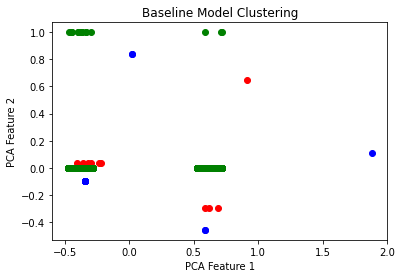

In [106]:
def add_random_noise(arr, noise_strength):
    for i, v in enumerate(arr):
        arr[i] = v + (np.random.rand() * noise_strength)
    
    return arr

chsc_pca = PCA(n_components=2)
chsc = chsc_pca.fit_transform(chsc)

hsnc_pca = PCA(n_components=2)
hsnc = hsnc_pca.fit_transform(hsnc)
hsnc[:, 0] = add_random_noise(hsnc[:, 0], 0.2)

wc_pca = PCA(n_components=2)
wc = wc_pca.fit_transform(wc)
wc[:, 0] = add_random_noise(wc[:, 0], 0.2)

fig, ax = plt.subplots()

ax.scatter(chsc[:, 0], chsc[:, 1], color='b')
ax.scatter(hsnc[:, 0], hsnc[:, 1], color='r')
ax.scatter(wc[:, 0], wc[:, 1], color='g')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('Baseline Model Clustering')

In [97]:
from sklearn.metrics import silhouette_score

chsc['cluster'] = [0] * len(chsc)
hsnc['cluster'] = [1] * len(hsnc)
wc['cluster'] = [2] * len(wc)

merged = pd.concat([chsc, hsnc, wc])

silhouette_score(merged.iloc[:, [0,1,2]], merged['cluster'])

/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.6582285856339486

## Data Preprocessing

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
df = customer_rfm.copy()
df = df.loc[:, ['last_order_days', 'order_count', 'avg_spending']]

In [27]:
df = df.dropna()

In [28]:
# TODO: more preprocessing proper scaling

In [29]:
mmscaler = MinMaxScaler()
df = pd.DataFrame(mmscaler.fit_transform(df))
df.columns = ['last_order_days', 'order_count', 'avg_spending']

## Model Selection

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Using Silhouette Score to get optimal cluster

Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...
Training model ...
Calculating silhouette score ...


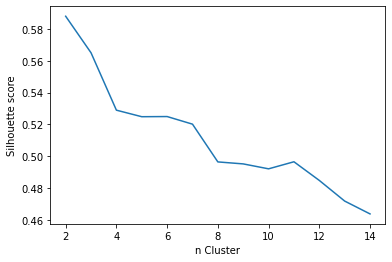

In [111]:
df1 = df.copy()
df1 = df.head(5000)

n_cluster = []
silhouette_scores = []

for i in range(2,15):
    print('Training model ...')
    kmeans = KMeans(n_clusters=i, random_state=111)
    y = kmeans.fit_predict(df1)
    print('Calculating silhouette score ...')
    sc = silhouette_score(df1, y)
    n_cluster.append(i)
    silhouette_scores.append(sc)

fig, ax = plt.subplots()

ax.plot(n_cluster, silhouette_scores)
ax.set_xlabel('n Cluster')
ax.set_ylabel('Silhouette score')

plt.show()

In [105]:
kmeans = KMeans(n_clusters=2, random_state=222)
y = kmeans.fit_predict(df)
sc = silhouette_score(df, y)
print("Silhouette score:", sc)

Silhouette score: 0.5863748806982205


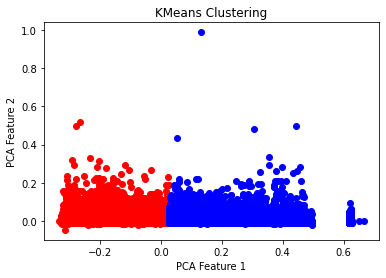

In [109]:
kmeans_pca = PCA(n_components=2)
kmeans_df = df.copy()
kmeans_df = kmeans_pca.fit_transform(kmeans_df)

kmeans_df = pd.DataFrame(kmeans_df)
kmeans_df['label'] = y

cluster_1 = kmeans_df[kmeans_df['label'] == 0]
cluster_2 = kmeans_df[kmeans_df['label'] == 1]

fig, ax = plt.subplots()

ax.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 1], color='r')
ax.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 1], color='b')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('KMeans Clustering')

plt.show()